# Libraries

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

# Input

In [2]:
E = 80e9 # youngs modulus
A = 1e-4 # section area

# Coordinate matrix

In [3]:
coord = np.array([[1, 0, 0],[2, 1.2,0.3],[3, 2.4,0],[4,1.2,0.8]])
nnos = np.size(coord,0)

# Incidence matrix

In [4]:
inci = np.array([[1, 1, 2],[2,2,3],[3,3,4],[4,4,1],[5,2,4]])
nel = np.size(inci,0)

# Boundary conditions

In [5]:
#   bc=[node | degree of freedom | value]
#
#   Degree of freedom 1 --> x
#   Degree of freedom 2 --> y

bc = np.array([[1,1,0],[1,2,0],[3,1,0],[3,2,0]])

# Mask stiffness matrix

In [6]:
mask = np.zeros((2*nnos,2*nnos))
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        mask[2*bc[i,0]-2,2*bc[i,0]-2] = 1
    elif bc[i,1] == 2:
        mask[2*bc[i,0]-1,2*bc[i,0]-1] = 1
mask = ma.masked_equal(mask, 1)
mask = ma.mask_rowcols(mask)
mask = (mask==False)

# Mask load vector

In [7]:
maskv = np.zeros(2*nnos)
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        maskv[2*bc[i,0]-2] = 1
    elif bc[i,1] == 2:
        maskv[2*bc[i,0]-1] = 1
maskv = ma.masked_equal(maskv, 1)
maskv = (maskv==False)

#  Load vector

In [8]:
#   F = [node | degree of freedom | value]
#
#   Degree of freedom 1 --> Fx
#   Degree of freedom 2 --> Fy

load = np.array([[2,2,-10e3]])

f = np.zeros((2*nnos,1)) # global force vector pre-allocation

for i in range(0,np.size(load,0)):
    if load[i,1] == 1:
        f[int(2*load[i,0]-2)] = load[i,2]
    elif load[i,1] == 2:
        f[int(2*load[i,0]-1)] = load[i,2]

# Global matrix assembly

In [9]:
kg = np.zeros((2*nnos,2*nnos)) # global stiffness matrix pre-allocation
for i in range(0,nel):
    node1 = inci[i,1] # first node element
    node2 = inci[i,2] # second node element

    x1 = coord[int(node1) - 1, 1]
    x2 = coord[int(node2) - 1, 1]

    y1 = coord[int(node1) - 1, 2]
    y2 = coord[int(node2) - 1, 2]

    l = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    if (x2-x1) ==0:
        if y2 > y1:
            theta = 2*np.arctan(1)
        else:
            theta =-2*np.arctan(1)
    else:
        theta = np.arctan((y2-y1)/(x2-x1))


    c = np.cos(theta)
    s = np.sin(theta)

    # local stiffness matrix
    ke = E*A/l*np.array([[c**2, c*s, -c**2, -c*s], [c*s, s**2, -c*s, -s**2], [-c**2, -c*s, c**2, c*s], [-c*s, -s**2, c*s, s**2]])

    # localization vector
    loc = [2*node1-2, 2*node1-1, 2*node2-2, 2*node2-1]

    # global stiffness matrix
    kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] = kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] +  ke
    
kg_aux = kg[mask.data]
kg_aux = np.reshape(kg_aux, (2*nnos-np.size(bc,0), 2*nnos-np.size(bc,0)))
f_aux  = f[maskv.data]

# Displacement

In [11]:
u = np.zeros((2*nnos, 1))
u[maskv.data] = np.linalg.solve(kg_aux, f_aux)
u_ = np.reshape(u,(nnos,2))
displacement_x = u_[:,0]
displacement_y = u_[:,1]

In [14]:
np.set_printoptions(precision=2)
print(u)

[[ 0.00e+00]
 [ 0.00e+00]
 [ 3.96e-20]
 [-2.80e-03]
 [ 0.00e+00]
 [ 0.00e+00]
 [-6.28e-20]
 [-2.31e-03]]


# Post-processing

In [15]:
factor = 50
new_coord = coord[:,1:3] + factor*u_

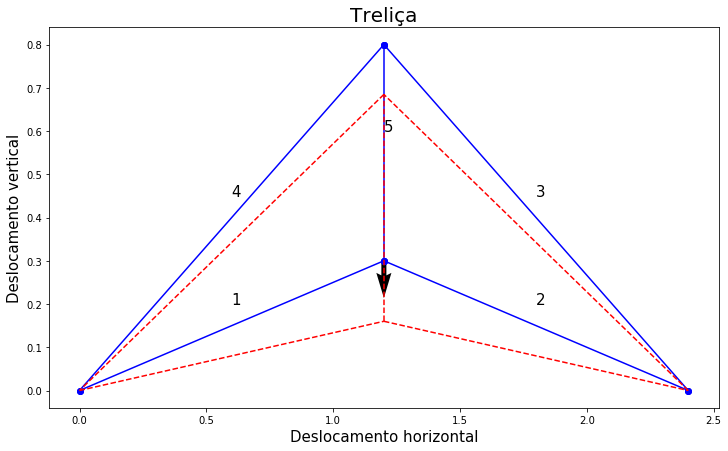

In [16]:
fig, ax = plt.subplots(figsize = (12, 7))

# original truss
for i in range(0, np.size(inci,0)):
    x1 = coord[int(inci[i,1]-1), 1]
    x2 = coord[int(inci[i,2]-1), 1]
    
    y1 = coord[int(inci[i,1]-1), 2]
    y2 = coord[int(inci[i,2]-1), 2]
    
    plt.plot([x1,x2], [y1,y2], 'bo-')
    
    s  = "{}".format(i+1)
    plt.text((x1+x2)/2, (y1+y2)/2 + 0.05, s, fontsize = 15)

# deformed truss
for i in range(0, np.size(inci,0)):
    x1 = new_coord[int(inci[i,1]-1), 0]
    x2 = new_coord[int(inci[i,2]-1), 0]
    
    y1 = new_coord[int(inci[i,1]-1), 1]
    y2 = new_coord[int(inci[i,2]-1), 1]
    
    plt.plot([x1,x2], [y1,y2], 'r--')    
    
# load applied
for i in range(0, np.size(load,0)):
    node = load[i,0]
    X = coord[int(node - 1), 1]
    Y = coord[int(node - 1), 2]
    U = 0
    V = 0
    if load[i,1] == 1:
        if load[i,2] > 0:
            U = 1
        else:
            U = -1
    elif load[i,1] == 2:
        if load[i,2] > 0:
            V = 1
        else:
            V = -1
    ax.quiver(X, Y, U, V)
    
fig.savefig('fem1b.png',dpi=300)                              # salvar figura como png (dpi = número de pixels)

plt.title('Treliça', fontsize = 20)
plt.xlabel('Deslocamento horizontal', fontsize = 15)
plt.ylabel('Deslocamento vertical', fontsize = 15)
    
plt.show()

# Tensão

In [17]:
stress = np.zeros((nel, 1))

for i in range(0,nel):
    node1 = inci[i,1] # first node element
    node2 = inci[i,2] # second node element

    x1 = coord[int(node1) - 1, 1]
    x2 = coord[int(node2) - 1, 1]

    y1 = coord[int(node1) - 1, 2]
    y2 = coord[int(node2) - 1, 2]

    l = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    if (x2-x1) ==0:
        if y2 > y1:
            theta = 2*np.arctan(1)
        else:
            theta =-2*np.arctan(1)
    else:
        theta = np.arctan((y2-y1)/(x2-x1))


    c = np.cos(theta)
    s = np.sin(theta)

    # local stiffness matrix
    ke = E*A/l*np.array([[c**2, c*s, -c**2, -c*s], [c*s, s**2, -c*s, -s**2], [-c**2, -c*s, c**2, c*s], [-c*s, -s**2, c*s, s**2]])

    # localization vector
    loc = [2*node1-2, 2*node1-1, 2*node2-2, 2*node2-1]

    d = u[[int(loc[0]),int(loc[1]),int(loc[2]), int(loc[3])]]

    elforce = np.matmul(ke,d)

    stress[i] = np.sqrt(elforce[1]**2 + elforce[2]**2)/A
    
    force_element = np.sqrt(elforce[1]**2 + elforce[2]**2)
    
    print("Normal force in element {0:5d} = {1:8.2f} N.".format(i + 1, force_element[0]))

    if ((x2-x1)*elforce[3])<0:
            stress[i]=-stress[i]

Normal force in element     1 =  4388.72 N.
Normal force in element     2 =  4388.72 N.
Normal force in element     3 =  7094.96 N.
Normal force in element     4 =  7094.96 N.
Normal force in element     5 =  7871.16 N.


# Reaction

In [18]:
F = np.matmul(kg,u)
maskv = (maskv==False)
F[maskv.mask]

array([[ 10161.05],
       [  5000.  ],
       [-10161.05],
       [  5000.  ]])